# Cross-Entropy Method

In the [previous notebook](./mc.ipynb), we saw how the Monte Carlo Method makes it possible to learn the value function, even if the transition probabilities are unknown. However, the method breaks down as soon as the state space becomes large or continuous. Then, it is no longer feasible to represent the values of all states in a table.


To approach this problem, one typically relies on a parametric approximation of the value function or the $Q$ function. In the present notebook, we discuss the effective and robust [Cross-Entropy Method](https://www.springer.com/de/book/9780387212401) as an approach for tackling the resulting challenge of estimating the optimal parameters.

## Approximating the Q-function

Ideally, when in a state $s \in \mathbb R^{d_s}$, the agent should choose the action $a \in A$ maximizing the expected discounted rewards, i.e., solve the optimization problem $\max_a Q(s, a)$. Even if the action space is small, this is a highly challenging task within the class of [noisy optimization problems](https://people.smp.uq.edu.au/DirkKroese/ps/CEopt.pdf), because the function $Q$ is not known in advance: it has to be learned from simulations. For this purpose, we first define a method, where the agent collects rewards according to a given approximation of the $q$-function.

In [6]:
import gym
import numpy as np

def episode(Q, env):
    """Simulate one episode of the environment
    
    # Arguments
        Q: Q function
        env: environment for the problem
        nsteps: maximal number of simulation steps
    # Result
        total reward during the episode
    """
    R  = 0
    s = env.reset()
    while True:
        q_vec = [Q(s, a) for a in range(env.action_space.n)]
        a = np.argmax(q_vec)
        
        s, r, d, _ = env.step(a)
        
        R += r
        if d:
            break
    return R

One possibility is to cast this task as a parametric estimation problem, by assuming that the function $Q = Q_\theta$ is parametrized by a suitable parameter vector $\theta$. 

To begin with, we consider linear parametrizations, where for each parameter action $a \in A$, there is a weight vector $w_a \in \mathbb R^{d_s}$ such that we approximate $Q(s, a)$ as 
$$Q_{w}(s, a) = w_a^\top s.$$

In [9]:
def q_apx(s, a, theta):
    return np.dot(theta[:, a], s)

## Learning via the Cross-Entropy Method

After the approximation $Q \approx Q_\theta$, we can now collect total rewards $\{R_i\}_{i \le N}$ from $N$ simulation runs with parameters $\{\theta_i\}_{i \le N}$. Due to the random initialization of the environment, the mapping $\theta_i \to R_i$ is in general still subject to random effects. The task is to find the parameter vector $\theta_{\mathsf {opt}}$ that maximizes the total expected rewards.

To this end, we resort to the **cross-entropy method**, which is a gradient-free, robust and versatile optimization technique. Here, we first generate the parameter vectors $\{\theta_i\}_{i \le N}$ according to a Gaussian proposal distribution with some mean $\mu$ and some covariance matrix $\Sigma$. Next, we collect associated rewards $\{R_i\}_{i \le N}$ and determine an **elite sample** $\{\theta_{i_1}, \dots, \theta_{i_{N'}}\}$ of size $N' \ll N$ corresponding to the $N'$ highest total rewards. Finally, we adapt the proposal distribution by updating $\mu$ and $\Sigma$ as the sample mean and sample covariance of the elite sample. In this way, the mean $\mu$ gradually approaches the optimal parameter vector $\theta_{\mathsf{opt}}$.

In [ ]:
mu_init = np.zeros((env.observation_space.shape[0], env.action_space.n))
std_init = np.ones((env.observation_space.shape[0], env.action_space.n))

nsamp = int(1e2)
nelite = int(1e1)
niter = int(2e1)

mu = mu_init
std = std_init
reward_trace = []

for _ in range(niter):
    thetas = np.random.randn(nsamp, *mu_init.shape) * std + mu
    
    rs = [episode(lambda s, a: q_apx(s, a, thetas[i, :, :]), env) 
          for i in range(nsamp)]
    
    reward_trace += [np.mean(rs)]
    
    elite_idxs  = np.argsort(rs)[-nelite:]
    thetas_elite = thetas[elite_idxs, :, :]
    
    mu = np.mean(thetas_elite, 3)
    std = np.std(thetas_elite, 0)

We see that this simple optimization scheme already learns quickly a useful policy.

Text(0, 0.5, 'reward')

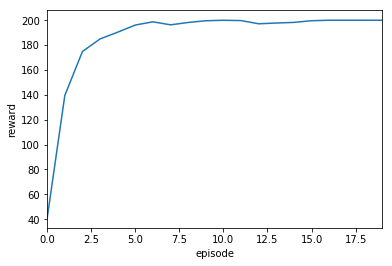

In [25]:
%matplotlib inline
import seaborn as sns
import pandas as pd

ax = pd.Series(reward_trace).plot()
ax.set_xlabel('episode')
ax.set_ylabel('reward')

We can also visualize how the learned policy works in practice.

In [27]:
nsteps = int(2e3)

s= env.reset()

for _ in range(nsteps):
    q_vec = [q_apx(s, a, mu) for a in range(2)]
    a = np.argmax(q_vec)
    
    s, _, d, _ = env.step(a)
    env.render()
    if d:
        break
env.close()